FACE DIRECTION(LEFT & RIGHT) CLASSIFACTION WITH CNN

This code is designed to classify head poses, determining the direction individuals are facing when looking at a camera. To achieve this, we will utilize a pre-trained model as the foundation, complemented by a custom Convolutional Neural Network (CNN) architecture to enhance performance and adaptability with respect to this task.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import cv2
import mediapipe as mp
from IPython.display import clear_output 


DATASET AND PRE-PROCESSING

For this model, we will utilize a custom liveliness dataset generated from video recordings of Qucoon staff. The participants were asked to record(picture or video) themselves turning their heads from left to right, ensuring the dataset captures a range of head poses.

The videos are processed by splitting them into individual frames using OpenCV, after which a face mesh is extracted from each frame. The face mesh, which contains 476 facial landmarks, is obtained using MediaPipe and will serve as both the training and validation data for the model.

To isolate the face mesh, each frame is converted to the HSV color space, and a mask is applied to extract only the blue channel, the color chosen for the face mesh representation. The resulting face mesh images form the raw dataset that will be used to train and test the model.

The above process produced  a dataset of 2197 images consisting of 1034 left images and 1163 right images

In [ ]:
#  --------------------FOR IMAGE DATA------------------------- #

#file directories
input_path = r'C:\Users\emman\Documents\python machine learning\Qoorify\good ones\modified images1 \new mod left' 

output_path = r"C:\Users\emman\Documents\python machine learning\Qoorify\good ones\modified images 2\new mod right"

# Initialize MediaPipe Face Mesh and Drawing utilities
face_connections = mp.solutions.face_mesh.FACEMESH_TESSELATION
face_mesh=mp.solutions.face_mesh.FaceMesh()
marks= mp.solutions.drawing_utils


# Loop through the image files in the directory
for img_file in os.listdir(input_path):
    if img_file.endswith(('.jpg', '.jpeg', '.png')):  # Ensure only image files are processed
        img_path = os.path.join(input_path, img_file)
        img1 = cv2.imread(img_path)
        
        if img1 is None:
            print(f"Error loading image {img_file}")
            continue
        
        # Convert the image to RGB because MediaPipe expects RGB input
        img_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

        # Process the image with Face Mesh
        results = face_mesh.process(img_rgb)

        # Check if any face landmarks were detected
        if results.multi_face_landmarks:
            # Loop over the detected faces
            for face_landmarks in results.multi_face_landmarks:
                # Draw the landmarks on the image
               marks.draw_landmarks(img1,face_landmarks,face_connections,
                                                        marks.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=1),
                                                        marks.DrawingSpec(color=(255, 0, 0), thickness=1)
                                                        )
        
        hsv = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
        # Save the image with the face mesh
        lower_blue = np.array([110,50,200])
        upper_blue = np.array([130,255,255])
    
        # Threshold the HSV image to get only blue colors
        mask = cv2.inRange(hsv, lower_blue, upper_blue)
    
        # Bitwise-AND mask and original image
        res = cv2.bitwise_and(img1,img1, mask= mask)
       
        output_img_path = os.path.join(output_path, f"face_mesh_{img_file}")
        cv2.imwrite(output_img_path, res)
        print(f"Image saved to {output_img_path}")




In [ ]:
#-------------------------FOR VIDEOS-------------------------#


cap = cv2.VideoCapture(r"C:\Users\emman\Documents\python machine learning\Qoorify\good ones\20241002_152536.mp4")

# Define output path
output_path = r"C:\Users\emman\Documents\python machine learning\Qoorify\output"  # Change this to your desired output folder

# Create the output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

frame_count = 58548  # Initialize frame count

while cap.isOpened():
    ret, img = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Process the image with Face Mesh
    results = face_mesh.process(img_rgb)

    # Check if any face landmarks were detected
    if results.multi_face_landmarks:
        # Loop over the detected faces
        for face_landmarks in results.multi_face_landmarks:
            # Draw the landmarks on the image
            marks.draw_landmarks(img, face_landmarks, face_connections,
                                 marks.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=1),
                                 marks.DrawingSpec(color=(255, 0, 0), thickness=1))

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Save the image with the face mesh
    lower_blue = np.array([110, 50, 50])
    upper_blue = np.array([130, 255, 255])

    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img, img, mask=mask)
    
    # Use frame count to create a valid filename
    output_img_path = os.path.join(output_path, f"face_mesh_frame_{frame_count}.jpg")
    cv2.imwrite(output_img_path, res)
    print(f"Image saved to {output_img_path}")

    frame_count += 142  # Increment frame count

cap.release()  # Release the video capture object


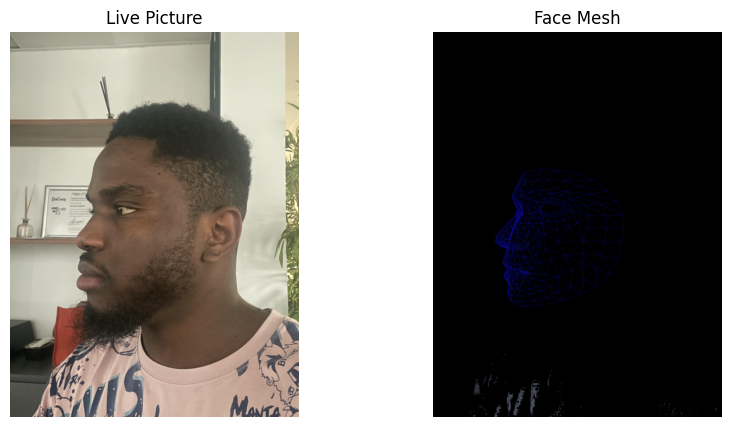

In [21]:


img1 = mpimg.imread(r"C:\Users\emman\Documents\python machine learning\Qoorify\good ones\modified images 2\new mod right\face_mesh_IMG_1925.jpg")
img2 = mpimg.imread(r"C:\Users\emman\Documents\python machine learning\Qoorify\good ones\Right\IMG_1925.jpg")

fig, pics = plt.subplots(1, 2, figsize=(10, 5))


pics[0].imshow(img2)
pics[0].axis('off')  
pics[0].set_title('Live Picture')


pics[1].imshow(img1)
pics[1].axis('off') 
pics[1].set_title('Face Mesh')

plt.show()

The dataset will be organized into different sub-folders and loaded using TensorFlow's ImageDataGenerator, which will handle the splitting of data into training and validation sets. During model training, the images will undergo augmentation—primarily horizontal flipping—but no additional pre-processing functions will be applied to the dataset, aside from the necessary scaling and validation split handled by the generator.

In [23]:
datagen1 = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Split into train/validation
)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Rotate images by a small angle
    horizontal_flip=True,  # Important for left/right classification
    brightness_range=[0.8, 1.2],
    validation_split=0.2 # Split into train/validation
)

train_generator = datagen.flow_from_directory(
    r'C:\Users\emman\Documents\python machine learning\Qoorify\good ones\modified images 2',  
    target_size=(224, 224),  # Resize images
    batch_size=32,
    class_mode='binary',  #  labels
    subset='training',
    seed=123,  
    shuffle=True    
)

validation_generator = datagen1.flow_from_directory(
     r'C:\Users\emman\Documents\python machine learning\Qoorify\good ones\modified images 2', 
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  
    subset='validation',
    seed=123,  
    shuffle=True     
)

Found 1759 images belonging to 2 classes.
Found 438 images belonging to 2 classes.


To address previous training issues, it is essential to review how images are presented to the model. The image below shows the augmented and rescaled 224x224 input.

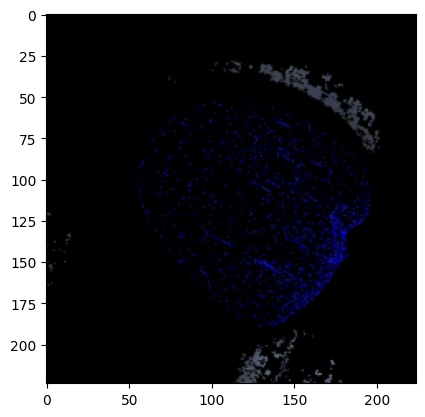

In [25]:


images, labels = next(train_generator)

# Visualize the first image with minimal preprocessing
plt.imshow(images[4])
plt.show()


BASE MODEL SELECTION

MobileNetV2 from google has been choosen because it is light weight,exceptionally fast and has exceptional accuracy in image classification.
It will be serving as the base layer for the neural network after removing it's top layer and making remaing layers not trainable.

In [128]:


base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),include_top=False,weights="imagenet")

In [129]:
base_model.trainable= False


CUSTOM CNN ARCHITECTURE

The base model has been  added to a GlobalAveragePooling2D layer to flatten out the dimensions from the output layer filters and make it easier for use to pass through our remaining layers without dimension errors.

BatchNormalization is used and in more than one layer to normalize the incoming data from the previous layer to reduce complexity and avoid over fitting.The purpose of the dropout layer is regularization of the data and is optional

relu and leaky relu have been applied to the dense neural network as they remove all negative values in the network and leaky relu does this better for hidden layers according to some sources.

sigmoid activation functions keeps values between -1 and 1 and has been proven to be the best output layer for binary classification


In [132]:
classifier2 = tf.keras.Sequential([
 base_model,
 tf.keras.layers.GlobalAveragePooling2D(),
 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.Dropout(0.3),
 tf.keras.layers.Dense(128, activation='relu'),
 tf.keras.layers.LeakyReLU(negative_slope=0.01),

 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.Dense(32,activation='relu',kernel_regularizer=l2(0.001)),

 tf.keras.layers.Dense(16,activation='relu'),
 tf.keras.layers.Dense(1, activation='sigmoid') ])

COMPILING THE NETWORK

The adam is the most common used optimizers because it can monitor the momentum as well as serve as a function to guide the back propergation to the best weights and biases at the right pace.

learning weight was adjusted a few times after training but is essentially the steps taken towards finding the minimum loss during training.

beta1 and beta 2 are the momentum of the Adam optimizer and were set manually because it was not learning as fast as expected but it was obvious from training it was getting somewhere.

binary_crossentropy serves as our loss function particulary because our task is binary classification(left and right) but while training the model's precision,recall and accuracy will be monitored alongside the loss.

In [133]:
classifier2.compile(optimizer = Adam(learning_rate=0.001, beta_1=0.96, beta_2=0.999), loss='binary_crossentropy',metrics=['accuracy', 'Precision', 'Recall'])

classifier2.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,432,257 (9.28 MB)

 Trainable params: 171,457 (669.75 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

\T/RAINING AND VALIDATION

The amount of epochs were changed continously but 12 seems to yeild the best results for now.
Each model is saved because when the results(sccuracy and loss) are approaching optimal values there may be slight variations, this way we can pick the model with the best weight in terms validation loss and accuracy.

This is why the validation loss has been picked as the metric to be monitored for early_stoppings.

In [134]:

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'classifier_epoch_{epoch:02d}.keras',  # Save model with epoch number in filename
    save_freq='epoch',  # Save weights at every epoch
    verbose=1  # Show saving progress
)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,  # Stop training after 5 epochs of no improvement
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Add both callbacks to your model's training
callbacks = [checkpoint, early_stopping]

# Use these callbacks during model training
history = classifier2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=12,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - Precision: 0.7070 - Recall: 0.5812 - accuracy: 0.6601 - loss: 0.6433
Epoch 1: saving model to classifier_epoch_01.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - Precision: 0.7078 - Recall: 0.5830 - accuracy: 0.6610 - loss: 0.6422 - val_Precision: 0.5896 - val_Recall: 0.9784 - val_accuracy: 0.6279 - val_loss: 0.6738
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - Precision: 0.8476 - Recall: 0.7549 - accuracy: 0.8010 - loss: 0.4541
Epoch 2: saving model to classifier_epoch_02.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - Precision: 0.8475 - Recall: 0.7554 - accuracy: 0.8011 - loss: 0.4540 - val_Precision: 0.6725 - val_Recall: 0.9914 - val_accuracy: 0.7397 - val_loss: 0.5831
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - Precision: 0.8888 - Recall: 0.8405 - accuracy: 0.8619 - loss: 0.3788
Epoch 3: saving model to classifier_epoch_03.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - Precision: 0.8886 - Recall: 0.8408 - accura

From the training output we can say that our network is performing slightly well. The losses for both train and validation reduced after each epoch which shows there is no overfitting and that the model is actually seeing patterns from the images being passed through it.

Validation accuracy is slightly lower than test accuracy showing the model has generalized patterns and is now able to work better with data it has not seen before.

Training and validation losses are to be close to 0.1 and in most epochs towards the end train loss was close to 0.1 and validation close to 0.4. These are fair results considering the little data given.

We can see the momentum per step played a role in the training during the epochs and we shall be going with epoch 09 for our final model.

The graphs below illustrate the analyses from the previous training, displaying both loss and accuracy values. Notably, there is a substantial, though not excessive, gap between the training and validation metrics.

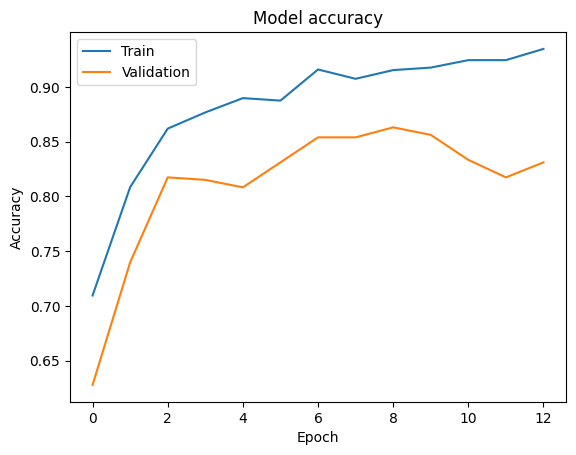

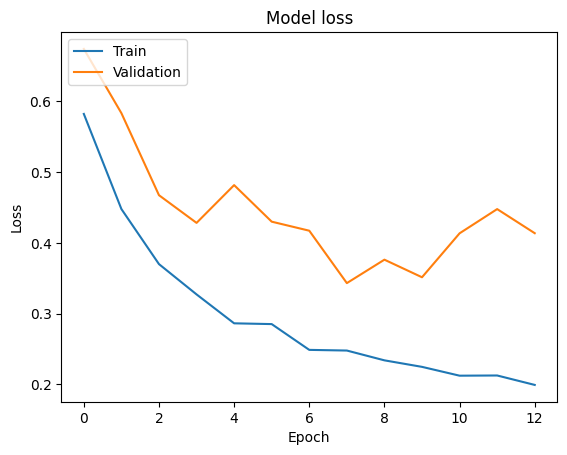

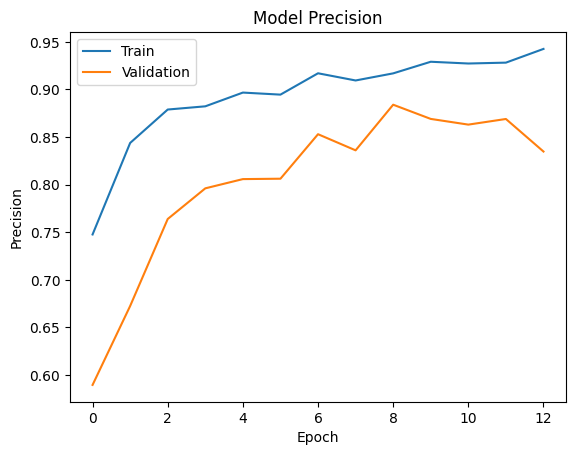

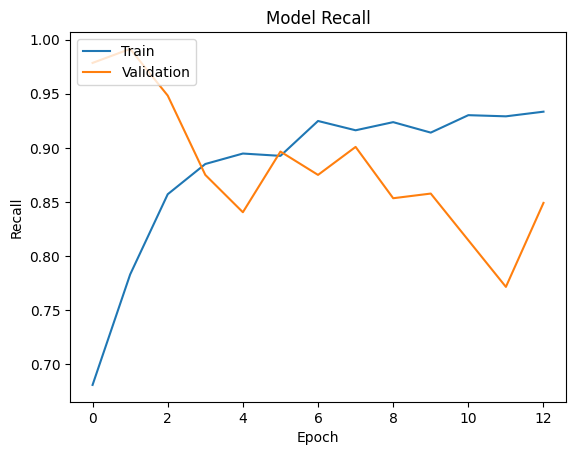

In [136]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['Precision'])
plt.plot(history.history['val_Precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['Recall'])
plt.plot(history.history['val_Recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


TESTING AND EVALUATION

To evaluate the saved model, a new set of images generated in the same manner as the training and validation datasets will be utilized. However, the number of images will be significantly reduced from over 2000 to 374(187 in each class). The evaluation will be conducted using TensorFlow's `model.evaluate()` function, along with a classification report generated by scikit-learn.

In [26]:
from tensorflow.keras.models import load_model

model_epoch_36 = load_model(r'C:\Users\emman\Documents\python machine learning\Qoorify\models\classifier_epoch_09(2).keras')


In [27]:
datagen3= ImageDataGenerator(
    rescale=1./255
)

In [28]:
dataset = datagen3.flow_from_directory(
     r'C:\Users\emman\Documents\python machine learning\Qoorify\good ones\modified images',  
    target_size=(224, 224),
    batch_size=16,
    class_mode= "binary",   
    seed=123,  
      )

Found 348 images belonging to 2 classes.


In [144]:
logs = model_epoch_36.evaluate(dataset)
print(logs)

c:\Users\emman\Documents\python machine learning\left\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 620ms/step - Precision: 0.6415 - Recall: 0.8789 - accuracy: 0.6864 - loss: 0.8523
[0.875424861907959, 0.6896551847457886, 0.6398305296897888, 0.8678160905838013]



The model was evaluated on a reduced dataset of 374 images, with 174 images in each class. The results indicate a precision of 0.6415, a recall of 0.8789, an accuracy of 0.6864, and a loss of 0.8523. The values in the brackets—[0.8754, 0.6897, 0.6398, 0.8678]—suggest that the model achieved a high recall (0.8754) and a moderate accuracy (0.6897). However, the precision (0.6398) indicates that there is still room for improvement in minimizing false positives. The loss value of 0.8678 reinforces the need for further refinement in the model's performance. Overall, while the model demonstrates promising capabilities, enhancements are necessary to improve its precision and overall effectiveness.

On the other hand, the model demonstrates excellent speed performance, predicting 374 images in just 14 seconds, resulting in an average of 0.003 seconds per image. This efficiency highlights that MobileNet was an appropriate choice as the base model, confirming its suitability for our KYC use case.

In [34]:
predictions = []
true_labels = []

for images, labels in dataset:
    # Predict the class probabilities
    preds = model_epoch_36.predict(images)
    # Convert probabilities to class labels (0 or 1)
    preds = (preds > 0.5).astype(int)
    
    # Append predictions and true labels
    predictions.extend(preds.flatten())
    true_labels.extend(labels.flatten())
    
    # Break after one full pass through the dataset
    if len(predictions) >= dataset.samples:
        break

clear_output(wait=True)  # wait=True will ensure the output is cleared before displaying new output

# Generate and print classification report
report = classification_report(true_labels, predictions)
print(report)

              precision    recall  f1-score   support

         0.0       0.79      0.51      0.62       174
         1.0       0.64      0.87      0.74       174

    accuracy                           0.69       348
   macro avg       0.72      0.69      0.68       348
weighted avg       0.72      0.69      0.68       348



The model exhibits varying performance across classes. Class 0.0 has a high precision of 0.79 but a low recall of 0.51, indicating it effectively identifies true positives while missing many actual instances. In contrast, Class 1.0 demonstrates more balanced metrics, with a precision of 0.64 and a recall of 0.87, suggesting effective identification of positive cases but potential for precision improvement.

Overall, the model achieves an accuracy of 0.69, with macro and weighted averages reflecting consistent performance across classes. However, the low recall for Class 0.0 indicates a need for further refinement to improve detection in this class.

In [30]:

preds2 = model_epoch_36.predict(dataset)


22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 604ms/step


To further assess the model's potential for failure, predictions were made on 10 images, yielding the following results:

In [35]:
# Assuming preds2 contains your model's predictions
print(preds2[:10].flatten())  # Print first 19 probabilities

# If preds2 is from model.predict, you need to round it or apply a threshold to convert to class labels
predicted_labels = (preds2 > 0.5).astype(int)  # Convert probabilities to 0 or 1 based on threshold 0.5

# Assuming you have your true labels stored in a variable (e.g., y_true), print the corresponding true labels
print(true_labels[:10])  # Print the first 19 true labels


[0.01229422 0.8006932  0.8112691  0.9621616  0.9944795  0.9960446
 0.98296034 0.85164046 0.9936908  0.8747531 ]
[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]


The model was tested on a sample of 10 images, achieving a commendable accuracy of 80% by correctly predicting 8 out of 10 instances. It performed well with a precision of 0.64 and a recall of 0.87 for positive cases (1.0), successfully identifying all positive instances while correctly predicting 4 out of 5 negative instances (0.0)

True Label 0.0: 4 out of 5 (correctly identified the first, third, ninth, and tenth predictions)
True Label 1.0: 3 out of 5 (correctly identified the second, fourth, fifth, and sixth predictions)
As a result, the model made 2 incorrect predictions: one instance of 0.0 was misclassified as 1.0, and one instance of 1.0 was misclassified as 0.0.

ERROR VISUALIZATION

To better understand the types of images the model is misclassifying, we will plot examples of both a misclassified image and a correctly classified image. Each will have a high confidence score, allowing us to identify potential errors in the data or model predictions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


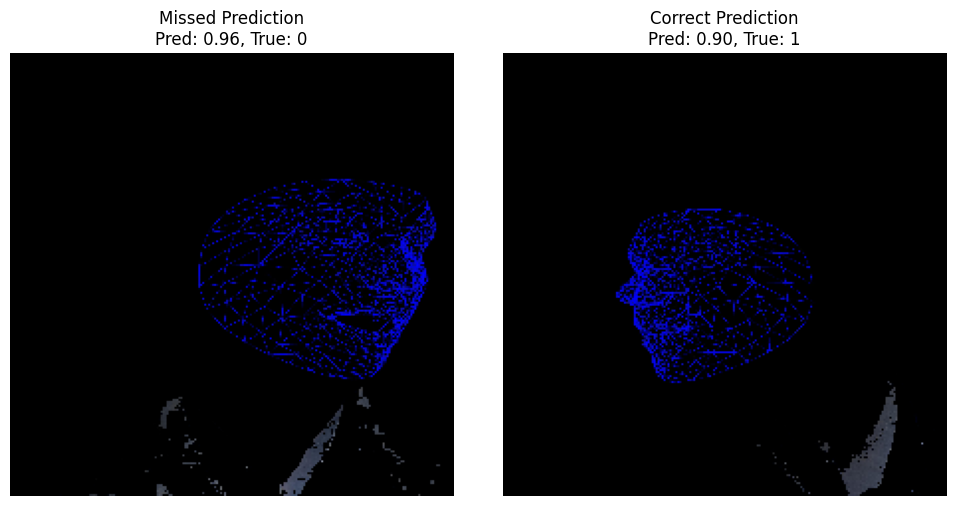

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and true labels
batch_images, batch_labels = next(dataset)

# Get predictions for the batch
predictions = model_epoch_36.predict(batch_images)

# Set confidence threshold for high confidence
confidence_threshold = 0.9

# Identify misclassified and correctly classified high-confidence images
high_confidence_missed = []
high_confidence_correct = []

for i in range(len(predictions)):
    prediction_val = predictions[i].item()  # Convert prediction to a single scalar value
    true_label = batch_labels[i].item()  # Convert label to a scalar value

    if prediction_val >= confidence_threshold:  # High confidence prediction
        if (prediction_val >= 0.5 and true_label == 0) or (prediction_val < 0.5 and true_label == 1):
            high_confidence_missed.append((batch_images[i], prediction_val, true_label))
        else:
            high_confidence_correct.append((batch_images[i], prediction_val, true_label))

# Plot the images
plt.figure(figsize=(10, 5))

# Plot the first missed high-confidence image
if high_confidence_missed:
    missed_image, missed_prediction, missed_label = high_confidence_missed[0]
    plt.subplot(1, 2, 1)
    plt.imshow(np.clip(missed_image, 0, 1))  # Adjust to [0, 1] range if necessary
    plt.title(f'Missed Prediction\nPred: {missed_prediction:.2f}, True: {int(missed_label)}')
    plt.axis('off')

# Plot the first correct high-confidence image
if high_confidence_correct:
    correct_image, correct_prediction, correct_label = high_confidence_correct[0]
    plt.subplot(1, 2, 2)
    plt.imshow(np.clip(correct_image, 0, 1))  # Adjust to [0, 1] range if necessary
    plt.title(f'Correct Prediction\nPred: {correct_prediction:.2f}, True: {int(correct_label)}')
    plt.axis('off')

plt.tight_layout()
plt.show()


The model appears to struggle with classifying images that contain extra gray patches, likely caused by the mask applied during preprocessing. It seems that the model has inadvertently learned to rely on these patches as minor features for classification. However, because these patches are random, they did not contribute significantly to improving the model’s accuracy, and this may be causing inconsistencies in predictions. Further refinement of the preprocessing or training process may be needed to reduce/eliminate this dependency.